In [7]:
import os
import pandas as pd
import re
import difflib
import json

In [8]:
rashi_masechtot = ['Arakhin', 'Bekhorot', 'Chullin', 'Keritot', 'Menachot', 'Temurah', 'Zevachim', 'Beitzah', 'Chagigah', 'Eruvin', 'Pesachim', 'Megillah', 'Rosh Hashanah', 'Shabbat', 'Sukkah', 'Yoma', 'Gittin', 'Ketubot', 'Kiddushin', 'Sotah', 'Yevamot', 'Bava Batra', 'Bava Kamma', 'Bava Metzia', 'Avodah Zarah', 'Makkot', 'Sanhedrin', 'Shevuot', 'Niddah', 'Berakhot']

mesorat_hashas_path2 = "/Users/ephraimmeiri/gitEtc/Rashi Thesis work/mesorat_hashas_links.json"
mesorat_hashas_file = open(mesorat_hashas_path2)
mesorat_hashas_json = json.load(mesorat_hashas_file)
mesorat_hashas_filtered = [link for link in mesorat_hashas_json if link['refs'][0].split(" ")[0] in rashi_masechtot and link['refs'][1].split(" ")[0] in rashi_masechtot]
shas_refs = [(link['refs'][0],link['refs'][1]) for link in mesorat_hashas_filtered]


In [35]:
def get_rashi_file(masechet):
    file = "/Users/ephraimmeiri/gitEtc/Rashi Thesis work/Rashi plaintext/json undisputed/Rashi on "+masechet+".json"
    if os.path.exists(file):
        with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work//Rashi plaintext/json undisputed/Rashi on "+masechet+".json") as f:
            data = json.load(f)
            return data
    else:
        return None

    # Possible cases for all locations:
    # 1. loc1 is a single daf, eg "2a"
    # 2. loc1 is a single daf with a line, eg "2a:3"
    # 3. loc1 i a singe daf with a range of lines, eg "2a:3-4"
    # 4. loc1 is a range of dafs, eg "2a-3b"
    # 5. loc1 is a range of dafs with a line, eg "2a:3-3b:4"
    # I think we might only really need to care about cases 2,3, and 5 for our links
def get_rashi_ref(ref,join=False):
    masechet,loc1,loc2= parse_ref(ref)
    rashi_file= get_rashi_file(masechet)
    if rashi_file is None:
        return None
    text= ""
    with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/Rashi plaintext/json undisputed/Rashi on "+masechet+".json") as f:
        data = json.load(f)['text']
        if loc2 is None:
            if "-" not in loc1:
                daf, line = loc1.split(":")
                print(line)
                daf_loc = daf_to_index(daf)
                if int(line) <= len(data[daf_loc]):
                    return data[daf_loc][int(line) - 1]  # TODO: Should this be line-1?
                else:
                    return None  # No rashi on this line
            elif "-" in loc1:
                daf, lines = loc1.split(":")
                line1, line2 = lines.split("-")
                daf_loc = daf_to_index(daf)
                if int(line1) <= len(data[daf_loc]):
                    return data[daf_loc][int(line1) :int(line2)]  # TODO: Should this be line-1?
                else:
                    return None  # No rashi on this line
        else:
            daf1, line1 = loc1.split(":")
            daf2, line2 = loc2.split(":")
            daf_loc1 = daf_to_index(daf1)
            daf_loc2 = daf_to_index(daf2)
            text = []
            if int(line1) <= len(data[daf_loc1]):
                text.append(data[daf_loc1][int(line1) - 1:])
            for daf in range(daf_loc1+1, daf_loc2):
                text.append(data[daf])
            if int(line2) <= len(data[daf_loc2]):
                text.append(data[daf_loc2][:int(line2)])                
        if join:
            while isinstance(text, list):
                # Join the list into a single string
                text = ' '.join(text)
        return text

def OLDget_rashi_ref(ref,join=False):
    masechet,loc1,loc2= parse_ref(ref)
    rashi_file= get_rashi_file(masechet)
    if rashi_file is None:
        return None
    masechet,loc1,loc2= parse_ref(ref)
    text= ""
    with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/Rashi plaintext/json undisputed/Rashi on "+masechet.replace(" ","%20")+".json") as f:
        data = json.load(f)['text']
        if loc2 is None:
            if ":" in loc1:
                daf, line = loc1.split(":")
                daf_loc = daf_to_index(daf)
                if int(line) <= len(data[daf_loc]):
                    return data[daf_loc][int(line) - 1]  # TODO: Should this be line-1?
                else:
                    return None  # No rashi on this line
        else:
            daf1, line1 = loc1.split(":")
            daf2, line2 = loc2.split(":")
            daf_loc1 = daf_to_index(daf1)
            daf_loc2 = daf_to_index(daf2)
            result = []
            if int(line1) <= len(data[daf]):
                result.append(data[daf][int(line1) - 1:])
            for daf in range(daf_loc1+1, daf_loc2):
                result.append(data[daf])
            if int(line2) <= len(data[daf]):
                result.append(data[daf][:int(line2)])
    if join:
        while isinstance(text, list):
            # Join the list into a single string
            text = ' '.join(text)
    return text

def OLDparse_ref(ref):
  masechet = ref.split(" ")[:-1] # Get all but the last element
  masechet= " ".join(masechet)
  if "-" not in ref:
    return masechet,ref.split(" ")[-1],None
  else:
    loc1,loc2= ref.split(" ")[-1].split("-")
    return masechet,loc1,loc2
  # if(len(ref.split(" ")[1].split("-"))==1):
  #   return masechet,loc1,None
  # else:
  #   loc2= ref.split(" ")[1].split("-")[1]
  #   return masechet,loc1,loc2
def daf_to_index(ref):
    daf = int(ref[:-1])
    amud= ref[-1]
    index= ((daf-1)*2)
    if(amud=="b"):
      index+= 1
    return index
def get_talmud_file(masechet):
    masechet = masechet.replace(" ","%20")
    with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/talmud_files/"+masechet+".json") as f:
        data = json.load(f)
        return data
def get_talmud_text(ref):
    masechet,loc1,loc2= parse_ref(ref)
    text= ""
    with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/talmud_files/"+masechet.replace(" ","%20")+".json") as f:
        data = json.load(f)
        index1,line1 = None,None # I'm doing it this way because of the multi-daf behavior
        if ":" not in loc1: # no line
            index1= daf_to_index(loc1)
        else: # has line
            index1= daf_to_index(loc1.split(":")[0])
            line1= int(loc1.split(":")[1])-1
        if loc2==None: # Since loc may have a line range (or just a single line)
            if ":" not in loc1: # no line
                text= data['text'][index1]
            else: # has line
                text= data['text'][index1][line1]
        elif not any(s in loc2 for s in ['a','b']): # loc 2 is a line within this daf
                text= data['text'][index1][line1:int(loc2)]
        else:
            if ":" not in loc2: # no line
                index2= daf_to_index(loc2)
                text= data['text'][index1:index2]
            else: # has
                index2= daf_to_index(loc2.split(":")[0])
                line2= int(loc2.split(":")[1])-1
                text = []
                for i in range(index1,index2+1):
                    # print(i)
                    if(i==index1):
                        text.append(data['text'][i][line1:][0])
                    elif(i==index2):
                        text.append(data['text'][i][:line2+1][0])
                    else:
                        text.append(data['text'][i][0])
    while isinstance(text, list):
        # Join the list into a single string
        text = ' '.join(text)
    return text

def get_rashis(link):
    ref1,ref2 = link
    rashi_text1 = get_rashi_ref(ref1)
    rashi_text2 = get_rashi_ref(ref2)
    return rashi_text1, rashi_text2

def get_match(matcher):
    a_start, b_start, = matcher.find_longest_match().a, matcher.find_longest_match().b
    a_end, b_end = a_start , b_start
    for match in matcher.get_matching_blocks()[:-1]: # "The last triple is a dummy, and has the value (len(a), len(b), 0)."
        if match.a < a_start:
            a_start= match.a
        if match.b < b_start:
            b_start= match.b
        if match.a + match.size > a_end:
            a_end= match.a + match.size
        if match.b + match.size > b_end:
            b_end= match.b + match.size
    return a_start, a_end, b_start, b_end

def sv_in_tal(rashi,tal,threshold=0.4):
    sv= rashi.split(" - ")[0]
    matcher = difflib.SequenceMatcher(None, sv, tal)
    match= matcher.find_longest_match()
    match = get_match(matcher)
    tal_extract = tal[match[2]:match[3]]
    matcher2= difflib.SequenceMatcher(None, sv, tal_extract)
    return matcher2.ratio()>threshold
    # return tal[match[2]:match[3]]

def get_rashis_conservative(link):
    ref1,ref2 = link
    rashi_text1 = get_rashi_ref(ref1)
    rashi_text2 = get_rashi_ref(ref2)
    if rashi_text1 is None or rashi_text2 is None:
        return None, None
    tal_text1 = get_talmud_text(ref1)
    tal_text2 = get_talmud_text(ref2)
    rashis1 = []
    for rashi in rashi_text1:
        if type(rashi)==str and sv_in_tal(rashi,tal_text2):
            rashis1.append(rashi)
        elif type(rashi)==list:
            for r in rashi:
                if sv_in_tal(r,tal_text2):
                    rashis1.append(r)
    rashis2 = []
    for rashi in rashi_text2:
        if type(rashi)==str and sv_in_tal(rashi,tal_text1):
            rashis2.append(rashi)
        elif type(rashi)==list:
            for r in rashi:
                if sv_in_tal(r,tal_text1):
                    rashis2.append(r)
    return rashis1, rashis2

In [26]:
def parse_ref(ref):
  masechet,dappim = ref.rsplit(" ",1) # Get all but the last element
  # masechet= " ".join(masechet)
  colons = dappim.count(":")
  if colons == 0:
    return masechet,dappim,None
  elif colons == 2:
    loc1,loc2= dappim.split("-")
    return masechet,loc1,loc2
  else:
    return masechet,dappim,None
  # if "-" not in ref:
  #   return masechet,ref.split(" ")[-1],None
  # else:
  #   loc1,loc2= ref.split(" ")[-1].split("-")
  #   return masechet,loc1,loc2

In [27]:
parse_ref("Bava Kamma 103b:6-104a:7")

('Bava Kamma', '103b:6', '104a:7')

In [20]:
parse_ref("Sanhedrin 103b:6")

('Sanhedrin', '103b:6', None)

In [21]:
parse_ref("Sanhedrin 103b:6-10")

('Sanhedrin', '103b:6-10', None)

In [28]:
get_rashi_ref("Sanhedrin 103b:6-10")

[['כתוב - (במלכים) [דה"ב לג] וישם את פסל הסמל אשר עשה בבית האלהים: ',
  'וכתיב והעמיד את האשרים והפסילים בד"ה (שם):',
  "ולבסוף עשה - מנשה לאותו דמות ד' פרצופים:",
  'כדי שתראה שכינה מכל צד - שתכנס להיכל תראה פרצוף כנגדו ותכעוס:'],
 [],
 ['מלהשתרר עליו שני רעים - שכינה ודמות הפרצוף:',
  'מצע - בית המקדש:',
  'תעשה לו מסכה צרה - כאשה שנעשית צרה לחברתה:'],
 ['העלה שממית - קורי עכביש שבטל עבודה מכל וכל עד שארגו עכביש קוריהן ע"ג המזבח:',
  'היתר - נעשה לו כהיתר:']]

In [29]:
get_rashi_ref("Sanhedrin 103b:6")

6


['הורג את כולן - שהיו נבקעין בכובד המשאוי:',
 'כמ"ד שהרג ישעיה - ואהא קאמר קרא מלא את ירושלים פה לפה שנשמתו של צדיק שקולה כמו שמלא את ירושלים חללים:']

In [36]:
get_rashi_ref("Bava Kamma 103b:6-104a:7")

[[[],
  ['עבוד רבנן תקנתא - תקנת השבים והכא דמספקא ליה תסגי להו במניח כדתניא עבוד תקנות גבי גוזל ונשבע והודה ואין הנגזל כאן דאע"פ דכתיב לאשר הוא לו תקון רבנן דנתביה לשליח בית דין ויהא תחת ידם עד שיבא נגזל ויטלנו:',
   'דקא מהדר ממונא למריה - לאחר זמן יחזירנו בית דין:\n'],
  ['לא נחלקו על שלקח - דכיון דליכא איסורא סגי ליה בהכי דלא כתיב לאשר הוא לו אלא במקום שחטא דבעי כפרה:\n'],
  ["מה לי לוקח כו' - הרי נשבע לשקר ואשבועת שקר כתיב לאשר הוא לו בין אגזל בין אתשומת יד דבהיתר אתא לידיה:"],
  ['עד שישלם לכל אחד - דהשבה לידיה בעינן ולא סגי במניח לפניו לומר מי שהוא שלו יטלנה:'],
  [],
  [],
  ["ור' טרפון מכדי כו' - אמתניתין פריך דאמר נשבע אין לא נשבע לא ואוקימנא כר' טרפון:",
   "לא סגיא דלא הודה - דכפרה והשבון דקרא אהודה כתיב דכתיב בגזל הגר והתודו את חטאתם וגו' (במדבר ה׳:ז׳):"]],
 [['שכבר הודה מפי עצמו - ובא לצאת ידי שמים ואע"ג דבי דינא לא מצו מחייבי ליה אלא מניח לפניהם מיהו ידי עונש אין יוצא עד שישלם לשניהם דהא לאו לבעלים אהדריה כו\':'],
  ['אלא אמר רבא - מתני\' דברי הכל היא ולא דמיא לאין יודע 

In [38]:
def get_text(file,loc1,loc2,join=False):
    text= ""
    data = file['text']
    if loc2 is None:
        if "-" not in loc1 and ":" in loc1:
            daf, line = loc1.split(":")
            print(line)
            daf_loc = daf_to_index(daf)
            if int(line) <= len(data[daf_loc]):
                return data[daf_loc][int(line) - 1]  # TODO: Should this be line-1?
            else:
                return None  # No rashi on this line
        elif "-" in loc1 and ":" in loc1:
            daf, lines = loc1.split(":")
            line1, line2 = lines.split("-")
            daf_loc = daf_to_index(daf)
            if int(line1) <= len(data[daf_loc]):
                return data[daf_loc][int(line1) :int(line2)]  # TODO: Should this be line-1?
            else:
                return None  # No rashi on this line
    else:
        daf1, line1 = loc1.split(":")
        daf2, line2 = loc2.split(":")
        daf_loc1 = daf_to_index(daf1)
        daf_loc2 = daf_to_index(daf2)
        text = []
        if int(line1) <= len(data[daf_loc1]):
            text.append(data[daf_loc1][int(line1) - 1:])
        for daf in range(daf_loc1+1, daf_loc2):
            text.append(data[daf])
        if int(line2) <= len(data[daf_loc2]):
            text.append(data[daf_loc2][:int(line2)])                
    if join:
        while isinstance(text, list):
            # Join the list into a single string
            text = ' '.join(text)
    return text

In [39]:
ref = "Sanhedrin 103b:6-10"
masechet,loc1,loc2= parse_ref(ref)
file = get_talmud_file(masechet)
get_text(file,loc1,loc2)

['כתיב פסל וכתיב פסילים אמר רבי יוחנן בתחלה עשה לו פרצוף אחד ולבסוף עשה לו ארבעה פרצופים כדי שתראה שכינה ותכעוס',
 'אחז העמידו בעלייה שנאמר ואת המזבחות אשר על הגג עלית אחז וגו׳ מנשה העמידו בהיכל שנאמר וישם את פסל האשרה אשר עשה בבית אשר אמר ה׳ אל דוד ואל שלמה [בנו] בבית הזה ובירושלים אשר בחרתי מכל שבטי ישראל אשים את שמי לעולם אמון הכניסו לבית קדשי הקדשים שנאמר כי קצר המצע מהשתרע והמסכה צרה כהתכנס',
 'מאי כי קצר המצע מהשתרע אמר רבי שמואל בר נחמני אמר רבי יונתן [כי] קצר המצע זה מלהשתרר עליו שני רעים כאחד מאי והמסכה צרה וגו׳ אמר רבי שמואל בר נחמני רבי יונתן כי הוה מטי להאי קרא הוה קא בכי מי שכתב בו ׳כנס כנד מי הים׳ תעשה לו מסכה צרה',
 '[אחז בטל את העבודה] וחתם את התורה שנאמר צור תעודה חתום תורה בלמודי מנשה קדר את האזכרות והרס את המזבח אמון שרף את התורה והעלה שממית על גבי המזבח אחז התיר את הערוה מנשה בא על אחותו']

In [40]:
text = [['מתיב רבי אמי המפיס מורסא בשבת אם לעשות לה פה חייב ואם להוציא ממנה ליחה'], ['פטור התם פקיד ועקיר הכא פקיד ולא עקיר']]

In [44]:
joined = ""
for t in text:
    joined+=" ".join(t)
joined

'מתיב רבי אמי המפיס מורסא בשבת אם לעשות לה פה חייב ואם להוציא ממנה ליחהפטור התם פקיד ועקיר הכא פקיד ולא עקיר'

In [45]:
sample_rashis = get_rashi_ref("Sanhedrin 103b:6-10")
joined = ""
for t in sample_rashis:
    joined+=" ".join(t)
joined

'כתוב - (במלכים) [דה"ב לג] וישם את פסל הסמל אשר עשה בבית האלהים:  וכתיב והעמיד את האשרים והפסילים בד"ה (שם): ולבסוף עשה - מנשה לאותו דמות ד\' פרצופים: כדי שתראה שכינה מכל צד - שתכנס להיכל תראה פרצוף כנגדו ותכעוס:מלהשתרר עליו שני רעים - שכינה ודמות הפרצוף: מצע - בית המקדש: תעשה לו מסכה צרה - כאשה שנעשית צרה לחברתה:העלה שממית - קורי עכביש שבטל עבודה מכל וכל עד שארגו עכביש קוריהן ע"ג המזבח: היתר - נעשה לו כהיתר:'

# Inspecting the data

In [55]:
results_df = pd.read_csv("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/rashi_conservative_output1.csv",index_col=0)

In [56]:
# filter our results where one of the txt fields is empty (ie empty list)
print(len(results_df))
results_df.head()

1954


,masechet1,masechet2,loc1,loc2,txt1,txt2
0,Ketubot,Shabbat,6b:13-7a:1,107a:3,['אם לעשות לה פה - שמתכוין ליפותה ולהיות לה פת...,"['המפיס - מבקע מורסא קויטור""א:', 'אם לעשות לה ..."
1,Niddah,Yevamot,67b:2,78a:20,['דבר תורה - הלכה למשה מסיני דאמר מר (סוכה דף ...,['משום דר\' יצחק דאמר דבר תורה רובו ומקפיד עלי...
2,Yoma,Zevachim,49a:1,14a:21-14b:2,['זר ואונן שיכור ובעל מום - כולהו נפקי לן מקרא...,['שיכור - היינו שתוי יין:']
3,Menachot,Niddah,76a:2,63a:11,['בעי רבי ירמיה - הא דקתני שף אחת היינו אמטויי...,['בעי רבי ירמיה האי שלש פעמים דקתני אמטויי ואת...
4,Pesachim,Pesachim,16a:16,20a:4,['אלא שאין מכשירים - אלמא הכשר תלושין דרבנן הו...,['משקה בית מטבחיא - שהודחה בהן אינו מכשיר:']


"['אם לעשות לה פה - שמתכוין ליפותה ולהיות לה פתח זה ליום מחר:', 'התם - גבי ליחה:', 'הכא - דם בתולים:']"

In [14]:
def contains_txt(rashi, txt):
    if isinstance(rashi, list):
        for r in rashi:
            if txt in r:
                return True
    elif isinstance(rashi, str):
        if txt in rashi:
            return True
    else:
        print("Unknown type")
    return False

In [88]:
term = "שמעתי"
results_df.apply(lambda x: contains_txt(x['txt1'], term) or contains_txt(x['txt2'],term), axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
1949    False
1950    False
1951    False
1952    False
1953    False
Length: 1954, dtype: bool

In [89]:
mask = results_df.apply(lambda x: contains_txt(x['txt1'], term) or contains_txt(x['txt2'],term), axis=1)
results_df[mask]

,masechet1,masechet2,loc1,loc2,txt1,txt2
14,Bekhorot,Niddah,10a:7,50b:2,['צריכה מחשבה - לטמא טומאת אוכלין אם נגע בהן ש...,['ואינה צריכה הכשר - כדיליף לקמן בשמעתין כל שס...
102,Chullin,Gittin,135b:3,22a:10,['טבל וחולין מעורבין זה בזה - ואפילו לאחר שחלק...,['טבל וחולין מעורבין זה בזה - אין לך פירי באיל...
114,Kiddushin,Zevachim,57a:7,70b:13,"['ה""ג ועגלה ערופה מאימתי אמר רבי ינאי כו\' - מ...",['ונסבין חברייא - וסבורין התלמידין מדעתם לומר:']
123,Gittin,Shabbat,79a:21,7a:9,"['וזרק - מרה""ר:', 'ונח על גביו חייב - דהויא לה...","[""נעץ קנה - סתמיה אין רחב ד':"", 'וזרק - מר""ה ו..."
131,Eruvin,Eruvin,35b:7,58a:2,"[""אם אינו יכול להבליעו - בפרק כיצד מעברין (עיר...","['בזו א""ר דוסתאי בר\' ינאי - בזו למעוטי ערי מק..."
143,Niddah,Zevachim,50b:2,105b:2,['ואינה צריכה הכשר - כדיליף לקמן בשמעתין כל שס...,['צריכה מחשבה - להצטרף פחות מכזית ממנה להשלים ...
230,Eruvin,Shevuot,31b:10,20b:13-21a:1,['כדאמר ליה רב פפא לאביי - לעיל בשמעתין:'],['מהו דתימא כדאמר ליה רב פפא לאביי - לקמן בשמע...
281,Gittin,Gittin,38b:11,52a:11,"['ומותבינן אשמעתין - אשמועת עצמינו:', ""אין הגז...",['מפני שהוא - האפוטרופוס:']
360,Yevamot,Yevamot,53a:6,96b:3-4,['מתניתין - דקתני אחת שתי יבמות עשה מאמר בזו ו...,"[""מתני' דלא כבן עזאי - מתני' דחשיב ביאה זו כמא..."
374,Bekhorot,Shabbat,55b:8,65b:4,"['ה""ג ופליגא דידיה אדידיה - כלומר פליגא דשמואל...","['ופליגא דידיה אדידיה - דשמואל אשמואל:', 'אין ..."


In [93]:
results_df[mask].iloc[0]['txt1']

'[\'צריכה מחשבה - לטמא טומאת אוכלין אם נגע בהן שרץ שאם תגע אחרי כן באוכלין כשרין תטמאם וכל כמה דלא חשיב עליה לית ביה שום טומאת מגע דנבלת עוף טהור אינה מטמאה אלא אם אכלה ואז מטמאה אותן בגדים שהוא לבוש בשעת בליעה:\', "ואינה צריכה הכשר - הואיל ויש עליה טומאה חמורה לטמא אדם ובגדים אם היה אוכלה ואמר בכריתות בפרק דם שחיטה (כריתות דף כא.) וכי יותן מים וכו\' מה זרעים מיוחדין שאין סופן לטמא טומאה חמורה צריכין הכשר אף כל שאין סופן לטמא טומאה חמורה צריכין הכשר ולא שייך הכשר אלא בטומאה קלה דאוכלין וכן מחשבה:"]'

In [95]:
results_str= ""
for i,row in results_df[mask].iterrows():
    results_str +=  row['masechet1']+" "+row["loc1"]+"\n"+ row['txt1'] + "\n" +row['masechet2']+" "+row["loc2"]+"\n"+ row['txt2'] + "\n\n-----------------\n\n"

In [97]:
with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/par שמעתי results.txt", "w") as text_file:
    text_file.write(results_str)

In [82]:
print(results_df.iloc[1318])
type(results_df.iloc[1318]['txt1'])

masechet1                                                Sotah
masechet2                                                 Yoma
loc1                                                    42a:14
loc2                                                    39a:14
txt1         ['למה סגן ממונה - לאיזה דבר הוא ממונה ומוכן. ש...
txt2         ["למה סגן מימינו כו' - שהולך תמיד לימינו כך אמ...
Name: 1318, dtype: object


str

In [109]:
term = "מצאתי"
mask = results_df.apply(lambda x: contains_txt(x['txt1'], term) or contains_txt(x['txt2'],term), axis=1)
results_df[mask]
results_str= ""
count =0
for i,row in results_df[mask].iterrows():
    count+=1
    results_str +=  row['masechet1']+" "+row["loc1"]+"\n"+ row['txt1'] + "\n" +row['masechet2']+" "+row["loc2"]+"\n"+ row['txt2'] + "\n\n-----------------\n\n"
print(results_str)
print(count)

Chullin 135b:3
['טבל וחולין מעורבין זה בזה - ואפילו לאחר שחלקו לא אמרינן יש ברירה וחלקו של עובד כוכבים הלך לו וזה חלק המגיע לישראל וטבל גמור הוא אלא אין ברירה וגם זה שנשאר חציו טבל וחציו חולין דיש קנין לעובד כוכבים בא"י להפקיע חלקו מיד מעשר. ואני שמעתי שאין לו תקנה לפי שאם בא להפריש נמצא מפריש מן הפטור על החיוב. ולי נראה שיש לו תקנה בשני צדדין אם יש לו טבל ממקום אחר מפריש על זה לפי חציו שאין חייב אלא חציו ואם אין לו טבל אחר מפריש מיניה וביה לפי כולו כגון אם יש לו עשרים מפריש שנים מהן שאם אין מפריש אלא אחד לא נפטר לפי שזה שהפריש יש חציו שאין שם מעשר חל עליו לפי שהוא פטור ועומד אבל כשמפריש שנים הרי השם חל על האחד ופוטר את העשרה המחוייבין והא ליכא למימר דילמא שניהם המופרשין בחלקו של עובד כוכבים גדלו ואין שם מעשר חל עליהם דתניא בגמרא דראש השנה (דף יב:) גבי חדש וישן המעורבין דקי"ל אין תורמין מזה על זה וקתני צובר את גרנו לתוכו ונמצא תורם מן החדש שבו על החדש שבו ומן הישן שבו על הישן שבו וכי היכי דפריש חדש וישן בחולין איכא נמי חדש וישן במעשר הכא נמי נמצא תורם מן החיוב שבו על החיוב שבו ומן הפטו

# Named Quotes

In [18]:
named_qotes_df= pd.read_csv("/Users/ephraimmeiri/Documents/רשי research docs/Quotatations etc/AllQuotes.csv",encoding='utf-8',names=["Masechet","Daf","Text","Search"])

In [27]:
named_qotes_df.head()

,Masechet,Daf,Text,Search
0,"רש""י מסכת שבת","דף י עמוד ב ד""ה משקל שני","משקל שני סלעים - לאו דוקא נקט, בתלמידי רבינו י...",#יצחק [1:3] הלוי
1,"רש""י מסכת שבת","דף כ עמוד א ד""ה תני רבי","כל אחד ואחד - כל עץ ועץ, ולא תימא כיון שאחזה ב...",#יצחק [1:3] הלוי
2,"רש""י מסכת ראש השנה","דף כט עמוד א ד""ה הכי גרסינן","אנדרוגינוס מוציא מינו - אנדרוגינוס כמותו, דאי ...",#יצחק [1:3] הלוי
3,"רש""י מסכת יומא","דף לט עמוד א ד""ה למה סגן",ואם בימינו של סגן עלה ראש בית אב אומר לו לכהן ...,#יצחק [1:3] הלוי
4,"רש""י מסכת סוכה","דף לה עמוד ב ד""ה תני ר'",תני ר' יצחק בר אלעזר נטלה בוכנתו - במתניתיה הו...,#יצחק [1:3] הלוי


In [128]:
# How many times does each Maasechet appear?
named_qotes_df['Masechet'].value_counts()

Masechet
  רש"י מסכת שבת           24
  רש"י מסכת חולין         19
  רש"י מסכת גיטין         11
  רש"י מסכת בבא קמא       11
  רש"י מסכת סוכה           6
  רש"י מסכת ראש השנה       6
  רש"י מסכת יבמות          5
  רש"י מסכת יומא           4
  רש"י מסכת בכורות         4
  רש"י מסכת קידושין        3
  רש"י מסכת מגילה          3
רש"י מסכת חולין            3
  רש"י מסכת עירובין        3
  רש"י מסכת עבודה זרה      2
רש"י מסכת בכורות           2
  רש"י מסכת כריתות         2
  רש"י מסכת נדה            2
  רש"י מסכת בבא מציעא      2
  רש"י מסכת זבחים          2
  רש"י מסכת ביצה           2
רש"י מסכת עירובין          1
רש"י מסכת ביצה             1
  רש"י מסכת שבועות         1
רש"י מסכת כתובות           1
רש"י מסכת תמורה            1
רש"י מסכת בבא מציעא        1
רש"י מסכת שבת              1
רש"י מסכת ברכות            1
  רש"י מסכת ברכות          1
  רש"י מסכת מנחות          1
רש"י מסכת זבחים            1
רש"י מסכת בבא מציעא        1
רש"י מסכת בבא קמא          1
רש"י מסכת קידושין          1
רש"י 

Clear the names need some cleaning.

In [28]:
named_qotes_df["Search"].value_counts()

Search
#מורי                                                       53
#רבינו הלוי                                                 16
‫#רבינו [1:3] יעקב                                          14
החיפוש : #גאו(ן/ם)                                          13
#מורי [1:3] הזק(ן/ם)                                        13
#יצחק [1:3] הלוי                                            10
#!יצחק [1:3] !יהוד(ה/א)                                     10
החיפוש : #!שאלתות                                           10
יצחק בר' מנחם                                                3
רבינו (סתם)                                                  2
יוסף טוב עלם                                                 2
מפי גאון ??                                                  2
רבינו משולם                                                  1
רבינו גרשום                                                  1
רבינו גרשם בר' יהודה                                         1
רבי אליעזר                                      

In [30]:
term= "‫#רבינו [1:3] יעקב"
mask = named_qotes_df.apply(lambda x: contains_txt(x["Search"], term))
named_qotes_df[mask]

KeyError: 'Search'

In [136]:
list(named_qotes_df["Search"].value_counts()[0:6].keys())

['#מורי ',
 '#רבינו הלוי ',
 '\u202b#רבינו [1:3] יעקב ',
 '#מורי [1:3] הזק(ן/ם) ',
 '#!יצחק [1:3] !יהוד(ה/א) ',
 '#יצחק [1:3] הלוי']

In [34]:
list(named_qotes_df["Masechet"].value_counts().keys())

['שבת',
 'חולין',
 'בבא קמא',
 'גיטין',
 'סוכה',
 'יבמות',
 'בכורות',
 'ראש השנה',
 'יומא',
 'עירובין',
 'כתובות',
 'בבא מציעא',
 'ביצה',
 'זבחים',
 'קידושין',
 'מגילה',
 'כריתות',
 'תמורה',
 'עבודה זרה',
 'ברכות',
 'נדה',
 'פסחים',
 'שבועות',
 'רש׳׳י מסכת קידושין',
 'חגיגה',
 'מנחות']

In [33]:
for i,row in named_qotes_df.iterrows():
    if type(row["Masechet"])==str:
        splt = row["Masechet"].split('רש"י מסכת ')
        if len(splt)>1:
            splt= splt[1]
        else:
            splt= splt[0]
        row["Masechet"]= splt.strip()
    else:
        print(row["Masechet"])

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [35]:
list(named_qotes_df["Masechet"].value_counts().keys())

['שבת',
 'חולין',
 'בבא קמא',
 'גיטין',
 'סוכה',
 'יבמות',
 'בכורות',
 'ראש השנה',
 'יומא',
 'עירובין',
 'כתובות',
 'בבא מציעא',
 'ביצה',
 'זבחים',
 'קידושין',
 'מגילה',
 'כריתות',
 'תמורה',
 'עבודה זרה',
 'ברכות',
 'נדה',
 'פסחים',
 'שבועות',
 'רש׳׳י מסכת קידושין',
 'חגיגה',
 'מנחות']

In [36]:
named_qotes_df[named_qotes_df["Masechet"]=="שבת"]

,Masechet,Daf,Text,Search
0,שבת,"דף י עמוד ב ד""ה משקל שני","משקל שני סלעים - לאו דוקא נקט, בתלמידי רבינו י...",#יצחק [1:3] הלוי
1,שבת,"דף כ עמוד א ד""ה תני רבי","כל אחד ואחד - כל עץ ועץ, ולא תימא כיון שאחזה ב...",#יצחק [1:3] הלוי
11,שבת,"דף כג עמוד א ד""ה הרואה - העובר","הרואה - העובר בשוק ורואה באחד החצרות דולק, ומצ...",#!יצחק [1:3] !יהוד(ה/א)
12,שבת,"דף פה עמוד ב ד""ה בנוטה שורה","דרומית, וכן כולן להרחיקן שלא יהיו זה כנגד זה, ...",#!יצחק [1:3] !יהוד(ה/א)
13,שבת,"דף צב עמוד א ד""ה משנה. שכן","משנה. שכן משא בני קהת - בכתף ישאו (במדבר ז), ו...",#!יצחק [1:3] !יהוד(ה/א)
14,שבת,"דף קיט עמוד א ד""ה סייניה - כובע",אכיל להו - סופך ליפול בידו. אותבה בסייניה - עש...,#!יצחק [1:3] !יהוד(ה/א)
20,שבת,"דף יב עמוד ב ד""ה סועד - סומך","סועד - סומך בתשות כחו, ומשום רבינו יעקב: סוער ...",‫#רבינו [1:3] יעקב
21,שבת,"דף יט עמוד א ד""ה מפליגין - מפרישין",מפליגין - מפרישין מן היבשה לים וזהו לשון [הפלג...,‫#רבינו [1:3] יעקב
22,שבת,"דף כג עמוד א ד""ה הרואה - העובר","הרואה - העובר בשוק ורואה באחד החצרות דולק, ומצ...",‫#רבינו [1:3] יעקב
107,שבת,"דף סז עמוד א ד""ה לכיפה","לכיפה - אונפול""ש +ומשמעו - בועה נפיחה תחת העור...",יצחק בר' מנחם


In [37]:
named_qotes_df[named_qotes_df["Masechet"]=="שבת"]["Search"].value_counts()

Search
#רבינו הלוי                 14
#!יצחק [1:3] !יהוד(ה/א)      4
‫#רבינו [1:3] יעקב           3
#יצחק [1:3] הלוי             2
החיפוש : #!שאלתות            2
יצחק בר' מנחם                1
#מורי [1:3] הזק(ן/ם)         1
החיפוש : #גאו(ן/ם)           1
Name: count, dtype: int64

In [57]:
named_qotes_df.groupby(['Masechet','Search']).size()

Masechet   Search               
בבא מציעא  #מורי                    1
           #מורי [1:3] הזק(ן/ם)     1
           החיפוש : #גאו(ן/ם)       1
           יצחק בר' מנחם            1
           רבינו משולם              1
                                   ..
שבת        החיפוש : #גאו(ן/ם)       1
           יצחק בר' מנחם            1
           ‫#רבינו [1:3] יעקב       3
תמורה      #מורי                    1
           יצחק בר' מנחם            1
Length: 83, dtype: int64

In [58]:
# Any duplicate locations?
named_qotes_df.groupby(['Daf']).size()

Daf
דף ב עמוד א ד"ה ועל לא             1
דף ד עמוד א ד"ה וזה גב             1
דף ד עמוד א ד"ה לא תקלל            1
דף ד עמוד א ד"ה לא תקלל            1
דף ו עמוד א ד"ה תורתו כסתום        1
                                  ..
דף קכד עמוד א ד"ה כתרטא - רובע     1
דף קכט עמוד א ד"ה פתורא דיונה      1
דף קלה עמוד ב ד"ה כתנאי - הא       2
דף קלט עמוד ב ד"ה ונותנין ביצה     1
דף קנו עמוד ב ד"ה במערב - שהוא     1
Length: 133, dtype: int64

## Graphing the data

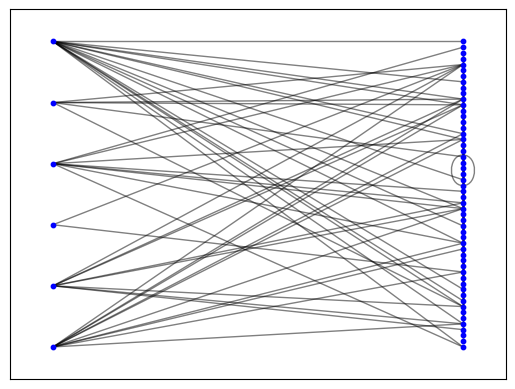

<Figure size 100000x100000 with 0 Axes>

In [146]:
import networkx as nx

import matplotlib.pyplot as plt

searches = list(named_qotes_df["Search"].value_counts()[0:6].keys())
masechtos = list(named_qotes_df["Masechet"].value_counts().keys())

G = nx.Graph()
G.add_nodes_from(searches, bipartite=0)
G.add_nodes_from(masechtos, bipartite=1)
for i,row in named_qotes_df.iterrows():
    G.add_edge(row["Search"], row["Masechet"], weight=1)
# Draw nodes
pos = nx.drawing.layout.bipartite_layout(G, searches)
nx.draw_networkx_nodes(G, pos, node_color='blue',node_size=10)

# Draw edges with width set to normalized weights
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)


plt.figure(figsize=(1000,1000))
plt.show()

# Getting better at generating searches

In [1]:
import rashi_functions as rfn
import pandas as pd
def generate_search(text):
    results_df= rfn.find_all(text)
    output= []
    for i,row in results_df.iterrows():
        daf = rfn.index_to_daf(row['Daf'])
        loc = str(row['Line'])+","+str(row['Comment'])
        output.append((row['Masechet'],daf,loc,row['Text']))
    return pd.DataFrame(output,columns=["Masechet","Daf","Loc","Text"])

SyntaxError: invalid syntax (rashi_functions.py, line 95)

In [18]:
kashya_li_results = generate_search("קשיא לי ")

In [19]:
kashya_li_results['Masechet'].value_counts()

Masechet
Chullin          11
Shabbat           9
Eruvin            7
Menachot          5
Yoma              4
Arakhin           3
Yevamot           3
Kiddushin         3
Ketubot           3
Bava Metzia       3
Pesachim          3
Beitzah           3
Zevachim          3
Avodah Zarah      2
Chagigah          2
Bava Kamma        2
Rosh Hashanah     2
Sanhedrin         1
Shevuot           1
Niddah            1
Sukkah            1
Gittin            1
Temurah           1
Keritot           1
Berakhot          1
Name: count, dtype: int64

In [20]:
kashya_li_results.to_csv("/Users/ephraimmeiri/Documents/רשי research docs/רשי תגובה וחידוש/לשונות ביקורת/kashya_li_results.csv",encoding='utf-8')

In [12]:
terms_of_interest=[
    "קשיא לי ",
    "קשה לי ",
    "אני אומר ",
    "אומר אני ",
    "גמגומ",
    "גמגום ",
    "טועין",
    "אפשר להעמידה",
    "יכול להעמידה",
    'וא"א להעמידה',
    "שיבוש",
    "משובש"
    "כמדומה לי",
    "נראה לי ",
    "נראה בעיני ",
    "בעיני נראה ",
    "שיטה זו בעיני",
    "לא ישרו בעיני",
    "ישר בעיני",
    "ישרה בעיני",
    " עיקר בעיני",
    "קשה בעיני ",
    "ולדידי קשיא",
    "פליאה בעיני ",
    "הגון בעיני",
    "ועיקר ",
    "וכן עיקר",
    "ללשון"
]

In [9]:
def composite_mask(results_df,terms):
    mask = None
    for term in terms:
        term_mask = results_df.apply(lambda x: contains_txt(x['txt1'], term) or contains_txt(x['txt2'],term), axis=1)
        if mask is None:
            mask = term_mask
        else:
            mask = mask | term_mask
    return mask
def filter_parallels(results_df,terms):
    mask = composite_mask(results_df,terms)
    return results_df[mask]
def output_parallels(results_df,terms):
    results_str= ""
    results = filter_parallels(results_df,terms)
    print(len(results), "results found")
    for i,row in filter_parallels(results_df,terms).iterrows():
        results_str +=  row['masechet1']+" "+row["loc1"]+"\n"+ row['txt1'] + "\n" +row['masechet2']+" "+row["loc2"]+"\n"+ row['txt2'] + "\n\n-----------------\n\n"
    return results_str

In [10]:
all_paralells = pd.read_csv('/Users/ephraimmeiri/gitEtc/Rashi Thesis work/rashi_conservative_output2.csv')

In [15]:
teguvah_paralells= output_parallels(all_paralells,terms_of_interest)

18 results found


In [16]:
with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/par תגובה results 2.txt", "w") as text_file:
    text_file.write(teguvah_paralells)

In [63]:
lashonMoriLA_results = generate_search("לשון מורי. ל")
lashonMoriLA_results2= generate_search("לשון מורי ל")
lashonMoriLA_results= pd.concat([lashonMoriLA_results,lashonMoriLA_results2])
lashonMoriLA_results

,Masechet,Daf,Loc,Text
0,Chullin,41a,"8,2","לתוך עוגה של מים - גומא כמו עוגיות לגפנים דמ""ק..."
1,Chullin,63a,"3,0",ומשפטיך אף בתהום רבה - שזמנתה שלך לשפוט ולעשות...
2,Chullin,95b,"14,1",אל תהי שוטה בחרוזים - בשאלה זו דודאי זה סימן ל...
3,Chullin,124a,"20,0","כתרטא - רובע הקב לשון מורי. ל""א כף מאזנים:"
4,Yevamot,25a,"0,1",מקום מנעלים הפוכים - ניכר מקום הפיכתן בעפר שתח...
5,Bava Kamma,36b,"10,0","התוקע - המכהו כנגד אזנו לשון מורי. ל""א תקיעה ממש:"
6,Bava Kamma,52a,"9,2","ושמואל אמר בכדי שיודיעוהו - אע""פ שלא בא וראהו ..."
7,Bava Kamma,61a,"8,2",אבל נכפפת - שהרוח מטה אותה וכופה לצדדין ומפסיק...
8,Bava Kamma,90a,"12,0",מתני' התוקע לחבירו - הכהו על אזנו לשון מורי. ל...
9,Bava Kamma,92b,"10,0","גללי - אבנים לשון מורי. ל""א גללים ממש וראשון י..."


In [65]:
for i,row in named_qotes_df.iterrows():
    if "לשון מורי ל" in row['Text'] or "לשון מורי, ל" in row['Text']:
        print(row['Masechet'],row['Daf'])

יבמות דף כה עמוד א ד"ה מקום מנעלים 
יבמות דף מח עמוד ב ד"ה אבל היכא 
יבמות דף נא עמוד ב ד"ה ואין מאמר 
גיטין דף יד עמוד ב ד"ה טב רמו 
בבא קמא דף לו עמוד ב ד"ה התוקע - המכהו 
בבא קמא דף נב עמוד א ד"ה ושמואל אמר 
בבא קמא דף סא עמוד א ד"ה אבל נכפפת 
בבא קמא דף צ עמוד א ד"ה מתני'. התוקע 
בבא קמא דף צב עמוד ב ד"ה גללי - אבנים 
בבא קמא דף קטז עמוד ב ד"ה דורמסקנין - פרושים 
חולין דף מא עמוד א ד"ה לתוך עוגה 
חולין דף מו עמוד א ד"ה ה"ג מאי 
חולין דף סג עמוד א ד"ה ומשפטיך אף 
חולין דף צה עמוד ב ד"ה אל תהי 
חולין דף קכד עמוד א ד"ה כתרטא - רובע 


TypeError: argument of type 'float' is not iterable

Comments missing:
חולין דף מו עמוד א ד"ה ה"ג מאי 
יבמות דף מח עמוד ב ד"ה אבל היכא 
The Lishna Achrina was parsed as a different comment.

In [71]:
lo_nireh_results = generate_search("ולא נראה")
lo_nireh_results

,Masechet,Daf,Loc,Text
0,Arakhin,9b,"0,0",במאי קמיפלגי - רב הונא דמוקי למתני' בתרתי מילי...
1,Chullin,59b,"3,3",חדורות - עגולות שמעתי ולא כשל עז שהן רחבות ולא...
2,Pesachim,73b,"6,1",ומתו בעלים אחר חצות - ונדחה מפסח דשוב אינו חוז...
3,Rosh Hashanah,20a,"3,2",הכא - דקתני מחללין כגון דאקלע יום שלשים ואחד ב...
4,Rosh Hashanah,20a,"17,1",בשאר ירחי לא - ואם תאמר מה צורך לנו בשאר חדשים...
5,Rosh Hashanah,22b,"6,0",להטעות את החכמים - שאירע יום ל' של אדר בשבת ול...
6,Shabbat,104b,"1,8","נתכוין לכתוב חי""ת - ודילג הקולמוס ולא נראה הגג..."
7,Ketubot,48a,"7,2","לא ניחא ליה דתינוול - אע""פ שלא צוה בלכתו עבדינ..."
8,Sanhedrin,10b,"1,0",חישוב לא קתני - דנימא שצריך שלשה לחשב אם יעברו...


In [72]:
for i,row in lo_nireh_results.iterrows():
    print(row['Masechet'],row['Daf'])
    print(row['Text'])
    print("---------------")

Arakhin 9b
במאי קמיפלגי - רב הונא דמוקי למתני' בתרתי מילי סבר לה כרשב"ג דזימנין כ"ט וזימנין שלשים והכי מיפרשא מתני' אין פוחתין מד' חדשים מעוברין דלא עבדינן טפי מח' חסירין הא ח' חסירין עבדינן ולא משכחת לה אלא במעוברת ועיבורה ל' וכדעולא ולא נראה לעבר יותר על שמונה הא שמונה מליאין עבדינן ובמעוברת ועיבורה כ"ט וכדלעיל והיינו כרבן שמעון ועולא סבר לה כת"ק דלעולם שלשים הלכך לא מיתוקמא מתני' אלא בחד טעמא ולא נראה לחסר יותר מח' קתני הא ח' עבדין ובמעוברת ועיבורה שלשים אבל לעבר אפילו ח' מליאין נמי לא עבדינן דקדים סיהרא שני יומי דמעוברת ועיבורה כ"ט ליכא לאוקומיה כרב הונא דאין עיבור שנה בציר משלשים:
---------------
Chullin 59b
חדורות - עגולות שמעתי ולא כשל עז שהן רחבות ולא נראה דכרוכות היינו עגולות כדאמר בב"ק (דף נ:) גבי שיחין ומערות ובבכורות (דף מ:) נמי גבי פיו דומה לשל חזיר והכי גרסינן חדורות כעין קרני איל וצבי שחדין למעלה:
---------------
Pesachim 73b
ומתו בעלים אחר חצות - ונדחה מפסח דשוב אינו חוזר ונראה לשלמים והא דקי"ל מותר הפסח אחר הפסח קרב שלמים כגון שאבד קודם חצות ונמצא אחר שחיטת הפסח דלא את

In [74]:
generate_search("לדידי קשיא")

,Masechet,Daf,Loc,Text
0,Kiddushin,11b,"1,0",הכי גרסי' ומה כסף דבר חשוב אף כלים דבר חשוב - ...
1,Bava Metzia,80b,"0,3",במחיקתא - אני שמעתי שעורין שהתליעו וכן בפירוש ...


In [ ]:
for i,row in ldidiK_results.iterrows():
    print(row['Masechet'],row['Daf'])
    print(row['Text'])
    print("---------------")

# Why no two words?

In [3]:
import os
import json
def get_rashi_file(masechet):
    file = "/Users/ephraimmeiri/gitEtc/Rashi Thesis work/Rashi plaintext/json undisputed/Rashi on "+masechet+".json"
    if os.path.exists(file):
        with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work//Rashi plaintext/json undisputed/Rashi on "+masechet+".json") as f:
            data = json.load(f)
            return data
    else:
        return None

In [4]:
get_rashi_file("Rosh Hashanah")

{'language': 'he',
 'title': 'Rashi on Rosh Hashanah',
 'versionSource': 'https://he.wikisource.org/wiki/תלמוד_בבלי',
 'versionTitle': 'WikiSource Rashi',
 'status': 'locked',
 'license': 'Public Domain',
 'versionTitleInHebrew': 'רש״י (ויקיטקסט)',
 'actualLanguage': 'he',
 'isBaseText': True,
 'heTitle': 'רש"י על ראש השנה',
 'categories': ['Talmud',
  'Bavli',
  'Rishonim on Talmud',
  'Rashi',
  'Seder Moed'],
 'text': [[[]],
  [],
  [["מתני' ארבעה ראשי שנים: למלכים - רגילים היו למנות זמן שטרותיהם לשנות המלך משנה שעמד בה המלך כדאמרינן במסכת גיטין (ד' פ.) משום שלום מלכות וקבעו חכמים אחד בניסן לתחלת שנתו ואפילו עמד בשבט או באדר כלתה שנתו משהגיע ניסן ויתחילו למנות לו שנה שניה:",
    "ולרגלים - מפרש בגמרא (ד' ד.):"],
   ['למעשר בהמה - שאין מעשרין מן הנולדים בשנה זו על הנולדים בחבירתה דכתיב (דברים י״ד:כ״ב-כ״ג) עשר תעשר את כל תבואת זרעך היוצא השדה שנה שנה ואמר מר בבכורות בפרק מעשר בהמה (בכורות דף נג:) בשתי מעשרות הכתוב מדבר אחד מעשר בהמה ואחד מעשר דגן:'],
   ["לשנים - מפרש בגמ' (דף ח.):",


In [5]:
def get_talmud_file(masechet):
    masechet = masechet.replace(" ","%20")
    with open("/Users/ephraimmeiri/gitEtc/Rashi Thesis work/talmud_files/"+masechet+".json") as f:
        data = json.load(f)
        return data
get_talmud_file("Rosh Hashanah")

{'language': 'he',
 'title': 'Rosh Hashanah',
 'versionSource': 'https://korenpub.co.il/collections/the-noe-edition-koren-talmud-bavli-1',
 'versionTitle': 'William Davidson Edition - Aramaic',
 'status': 'locked',
 'license': 'CC-BY-NC',
 'versionNotes': "Aramaic from The William Davidson digital edition of the <a href='https://korenpub.co.il/collections/the-noe-edition-koren-talmud-bavli-1'>Koren Noé Talmud</a>, with commentary by <a href='/adin-even-israel-steinsaltz'>Rabbi Adin Even-Israel Steinsaltz</a>",
 'versionTitleInHebrew': 'מהדורת וויליאם דייוידסון - ארמית',
 'versionNotesInHebrew': "טקסט ארמי של תלמוד מהדורת ויליאם דיוידסון מתוך מהדורת <a href='https://korenpub.co.il/collections/the-noe-edition-koren-talmud-bavli-1'>Noé</a> עם פירוש <a href='/adin-even-israel-steinsaltz'>הרב עדין אבן ישראל שטיינזלץ</a>, בהוצאת קורן ירושלים",
 'purchaseInformationImage': 'https://storage.googleapis.com/sefaria-physical-editions/7d93a8f239b2c73523d3b2e9399ce1a8.png',
 'purchaseInformationURL

In [4]:
import pandas as pd 
file_path = "/Users/ephraimmeiri/gitEtc/Rashi Thesis work/parallels/rashi_conservative_output3.csv"
paralles = pd.read_csv(file_path,header=0,index_col=0)
paralles

,masechet1,masechet2,loc1,loc2,txt1,txt2
0,Bava Metzia,Eruvin,39b:2,29a:19-29b:1,['אבל בבתי לית לן בה - שהשכנים מעידין עליהם שב...,['עלין - לא חשיבי ורעים לאכול:']
1,Ketubot,Shabbat,6b:13-7a:1,107a:3,['אם לעשות לה פה - שמתכוין ליפותה ולהיות לה פת...,"['המפיס - מבקע מורסא קויטור""א:', 'אם לעשות לה ..."
2,Niddah,Yevamot,67b:2,78a:20,['דבר תורה - הלכה למשה מסיני דאמר מר (סוכה דף ...,['משום דר\' יצחק דאמר דבר תורה רובו ומקפיד עלי...
3,Yoma,Zevachim,49a:1,14a:21-14b:2,['זר ואונן שיכור ובעל מום - כולהו נפקי לן מקרא...,['שיכור - היינו שתוי יין:']
4,Pesachim,Pesachim,16a:16,20a:4,['אלא שאין מכשירים - אלמא הכשר תלושין דרבנן הו...,['משקה בית מטבחיא - שהודחה בהן אינו מכשיר:']
...,...,...,...,...,...,...
2459,Bava Kamma,Sanhedrin,91a:8,45a:12,"[""[מה בור] - סתם בור י' טפחים:""]",['מה בור שהוא כדי להמית - משנה היא בבבא קמא (ד...
2460,Bava Metzia,Yevamot,114b:2,61a:1,"['לאו כהן מר - דאיכא למ""ד דאליהו הוא פינחס דכת...",['אין מטמאין - את המאהיל עליהם:']
2461,Chagigah,Pesachim,2a:7-2b:2,88a:18-88b:2,"[""לישא שפחה אינו יכול - מפני צד החרות שבו וכתי...",['לישא שפחה אינו יכול - דצד חירות אסור בה דכתי...
2462,Pesachim,Zevachim,96b:19-97a:1,37b:7,['יכול אף לפני הפסח כן - תמורת הפסח שנמצא לפני...,"['אם כשב - ובשלמים כתיב:', 'שקריבה שלמים - שהר..."


In [9]:
mas1= "Shabbat"
mas2 = "Eruvin"
paralles_mas1 = paralles[(paralles["masechet1"]==mas1) & (paralles["masechet2"]==mas2)]
paralles_mas2 = paralles[(paralles["masechet1"]==mas2) & (paralles["masechet2"]==mas1)]

In [10]:
print(len(paralles_mas1),len(paralles_mas2))

0 41
